# TRADING CUANTITATIVO

#### CONTEXTO

- Mercado: EUR/USD
- Timeframe: 1H
- Descarga de datos (3 años)
- Features sin fuga (“solo velas cerradas”)
- Target (próxima vela)
- Validación temporal + walk-forward opcional
- Modelo baseline + Gradient Boosting
- Backtest más realista con costos (spread + comisión + slippage)
- Métricas de trading (equity, CAGR aprox, max drawdown, Sharpe aprox)

>**Nota:** Esto es para aprender el pipeline. No es consejo financiero.

## 0) Instalación

In [2]:
!pip install yfinance pandas numpy scikit-learn matplotlib



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: C:\Users\TRENDINGPC\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [4]:
import sys
!{sys.executable} -m pip install yfinance


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.6 MB 3.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.3/1.6 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 3.3 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15690 sha256=f73bbb48914212708c1e3c83f1fc86c93a088e37d7c1b69a20017b4eff5d53b7
  Stored in directory: c:\users\trendingpc\appdata\local\pip\cache\wheels\7e\62\f9\20d7dbb144b6f563edab8e3a7fda71d976870cd41972035cdd
Successfully built multitasking

   ---------------------------------------- 0/

In [5]:
import yfinance as yf


## 1) Descargar datos EURUSD 1H (3 años)

In [7]:

import yfinance as yf
import pandas as pd

symbol = "EURUSD=X"
df = yf.download(symbol, period="730d", interval="1h", auto_adjust=False, progress=False)

# yfinance a veces devuelve columnas MultiIndex cuando hay tickers
df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
df = df.rename(columns=str.lower).dropna().copy()

df.head(), df.tail(), df.shape


(                           adj close     close      high       low      open  \
 Datetime                                                                       
 2023-04-13 23:00:00+00:00   1.105461  1.105461  1.105461  1.105094  1.105094   
 2023-04-14 00:00:00+00:00   1.105705  1.105705  1.106317  1.105217  1.105217   
 2023-04-14 01:00:00+00:00   1.106684  1.106684  1.106684  1.105705  1.105828   
 2023-04-14 02:00:00+00:00   1.107665  1.107665  1.107788  1.106684  1.106684   
 2023-04-14 03:00:00+00:00   1.107297  1.107297  1.107665  1.106929  1.107297   
 
                            volume  
 Datetime                           
 2023-04-13 23:00:00+00:00       0  
 2023-04-14 00:00:00+00:00       0  
 2023-04-14 01:00:00+00:00       0  
 2023-04-14 02:00:00+00:00       0  
 2023-04-14 03:00:00+00:00       0  ,
                            adj close     close      high       low      open  \
 Datetime                                                                       
 2026-01-

## 2) Limpieza básica + checks

In [8]:
# Quitar velas inválidas (muy raro, pero buena práctica)
df = df[(df["high"] >= df["low"]) & (df["close"] > 0)].copy()

# Asegura índice datetime y orden
df = df.sort_index()
df.index = pd.to_datetime(df.index)

df.isna().sum()


adj close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

In [9]:
# Verificando que el DataFrame no esté vacío
if df.empty:
    raise ValueError("El DataFrame está vacío después de la limpieza de datos.")    
df.head(), df.tail(), df.shape
df.info()
df.describe()
df.index.min(), df.index.max()
df.index.freq  # None porque hay huecos en los datos
df = df.asfreq('H')  # Reindexa con frecuencia horaria
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17272 entries, 2023-04-13 23:00:00+00:00 to 2026-01-29 18:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj close  17272 non-null  float64
 1   close      17272 non-null  float64
 2   high       17272 non-null  float64
 3   low        17272 non-null  float64
 4   open       17272 non-null  float64
 5   volume     17272 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 944.6 KB


C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_6056\2343294818.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')  # Reindexa con frecuencia horaria


adj close    7252
close        7252
high         7252
low          7252
open         7252
volume       7252
dtype: int64

## 3) Features (solo con información pasada)

#### Estas features son “clásicas” y seguras para empezar.

In [10]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    d = data.copy()

    # Retornos
    d["ret_1"]  = d["close"].pct_change(1)
    d["ret_3"]  = d["close"].pct_change(3)
    d["ret_6"]  = d["close"].pct_change(6)
    d["ret_12"] = d["close"].pct_change(12)
    d["ret_24"] = d["close"].pct_change(24)

    # Medias
    d["sma_10"] = d["close"].rolling(10).mean()
    d["sma_30"] = d["close"].rolling(30).mean()
    d["sma_ratio"] = d["sma_10"] / d["sma_30"] - 1

    # Volatilidad rolling
    d["vol_20"] = d["ret_1"].rolling(20).std()

    # Rango relativo (proxy ATR simple)
    d["range"] = (d["high"] - d["low"]) / d["close"]

    # Velas (cuerpo y mechas) - normalizadas
    d["body"] = (d["close"] - d["open"]) / d["close"]
    d["upper_wick"] = (d["high"] - d[["close","open"]].max(axis=1)) / d["close"]
    d["lower_wick"] = (d[["close","open"]].min(axis=1) - d["low"]) / d["close"]

    return d

df_feat = add_features(df)
df_feat = df_feat.dropna().copy()
df_feat.head()


C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_6056\3869259806.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  d["ret_1"]  = d["close"].pct_change(1)
C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_6056\3869259806.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  d["ret_3"]  = d["close"].pct_change(3)
C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_6056\3869259806.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None'

,adj close,close,high,low,open,volume,ret_1,ret_3,ret_6,ret_12,ret_24,sma_10,sma_30,sma_ratio,vol_20,range,body,upper_wick,lower_wick
Datetime,,,,,,,,,,,,,,,,,,,
2023-04-18 04:00:00+00:00,1.094212,1.094212,1.094331,1.093733,1.093853,0.0,0.000000,0.000547,0.001313,0.002517,-0.004049,1.093374,1.095421,-0.001868,0.000907,0.000547,0.000328,0.000109,0.000109
2023-04-18 05:00:00+00:00,1.094811,1.094811,1.094811,1.093733,1.094092,0.0,0.000547,0.001095,0.001642,0.001971,-0.004270,1.093518,1.095293,-0.001620,0.000858,0.000984,0.000656,0.000000,0.000328
2023-04-18 06:00:00+00:00,1.095290,1.095290,1.095410,1.093853,1.094451,0.0,0.000438,0.000986,0.002300,0.002191,-0.003505,1.093745,1.095213,-0.001340,0.000864,0.001422,0.000766,0.000109,0.000547
2023-04-18 07:00:00+00:00,1.097333,1.097333,1.097333,1.095050,1.095170,0.0,0.001865,0.002853,0.003402,0.003621,-0.001975,1.094165,1.095209,-0.000953,0.000971,0.002081,0.001971,0.000000,0.000109
2023-04-18 08:00:00+00:00,1.098418,1.098418,1.098539,1.096972,1.096972,0.0,0.000989,0.003295,0.004394,0.004943,0.001428,1.094729,1.095209,-0.000438,0.000867,0.001426,0.001316,0.000110,0.000000


## 4) Target: dirección de la próxima vela (t+1)

In [11]:
# Target: 1 si la próxima vela cierra arriba; 0 si no
df_feat["target"] = (df_feat["close"].shift(-1) > df_feat["close"]).astype(int)

# Quitamos última fila (no tiene target)
df_feat = df_feat.dropna().copy()

feature_cols = [
    "ret_1","ret_3","ret_6","ret_12","ret_24",
    "sma_ratio","vol_20","range",
    "body","upper_wick","lower_wick"
]

X = df_feat[feature_cols]
y = df_feat["target"]

X.shape, y.value_counts(normalize=True)


((12862, 11),
 target
 0    0.540662
 1    0.459338
 Name: proportion, dtype: float64)

## 5) Split temporal (80/20) + baseline y Gradient Boosting

In [12]:
split = int(len(df_feat) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=300))
])

pipe_lr.fit(X_train, y_train)
proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("LogReg AUC:", roc_auc_score(y_test, proba_lr))
print(classification_report(y_test, pred_lr))


LogReg AUC: 0.5265316690120682
              precision    recall  f1-score   support

           0       0.55      0.97      0.70      1403
           1       0.54      0.04      0.07      1170

    accuracy                           0.55      2573
   macro avg       0.55      0.51      0.39      2573
weighted avg       0.55      0.55      0.41      2573



#### Ahora Gradient Boosting (suele funcionar muy bien como primer “modelo serio” sin libs extra):

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

proba_gb = gb.predict_proba(X_test)[:, 1]
pred_gb = (proba_gb >= 0.5).astype(int)

print("GB AUC:", roc_auc_score(y_test, proba_gb))
print(classification_report(y_test, pred_gb))


GB AUC: 0.5310525065336185
              precision    recall  f1-score   support

           0       0.55      0.83      0.66      1403
           1       0.48      0.19      0.27      1170

    accuracy                           0.54      2573
   macro avg       0.52      0.51      0.47      2573
weighted avg       0.52      0.54      0.48      2573



## 6) Backtest con costos (spread + comisión + slippage)

#### Supuestos de costos (ajustables)

- **spread_pips:** spread promedio en pips (EURUSD típico 0.6–1.5 pips en broker decente)
- **slippage_pips:** Deslizamiento promedio por entrada/salida
- **commission_per_round_turn:** comisión por ida y vuelta (si aplica). En FX retail a veces viene “embebida” en spread (pon 0).

>1 pip en EURUSD = 0.0001 (aprox).

Costos se aplican **cuando cambias de posición** (trade).


In [14]:
import matplotlib.pyplot as plt

def backtest_directional(
    prices: pd.Series,
    proba: pd.Series,
    threshold: float = 0.55,
    spread_pips: float = 1.0,
    slippage_pips: float = 0.2,
    commission_round_turn: float = 0.0
):
    """
    Estrategia:
    - si P(up) >= threshold -> long (+1)
    - si P(up) <= 1-threshold -> short (-1)
    - si está en zona gris -> flat (0)
    Ejecuta en la siguiente vela (retorno t->t+1).
    Costos:
    - al cambiar posición se paga (spread+slippage) en pips (por lado aproximado) -> round-turn aproximado
    """
    df_bt = pd.DataFrame({"close": prices, "proba": proba}).copy()

    # Retorno forward (siguiente vela)
    df_bt["fwd_ret"] = df_bt["close"].pct_change().shift(-1)

    # Señal con zona gris
    df_bt["pos"] = 0
    df_bt.loc[df_bt["proba"] >= threshold, "pos"] = 1
    df_bt.loc[df_bt["proba"] <= (1 - threshold), "pos"] = -1

    # Cambio de posición (trade)
    df_bt["pos_prev"] = df_bt["pos"].shift(1).fillna(0)
    df_bt["trade"] = (df_bt["pos"] != df_bt["pos_prev"]).astype(int)

    # Costo por trade en retorno:
    # Convertimos pips a "return" aproximado dividiendo por precio.
    pip_value = 0.0001
    total_pips = spread_pips + slippage_pips  # simplificación
    df_bt["cost_ret"] = df_bt["trade"] * (total_pips * pip_value) / df_bt["close"]

    # Comisión: si quieres modelarla como retorno fijo por trade (aprox), puedes sumarla aquí.
    # Para mantenerlo simple la dejamos como 0 o la conviertes a ret sobre capital.
    df_bt["commission_ret"] = df_bt["trade"] * commission_round_turn

    # Retorno estrategia
    df_bt["strategy_ret"] = df_bt["pos"] * df_bt["fwd_ret"] - df_bt["cost_ret"] - df_bt["commission_ret"]

    df_bt = df_bt.dropna().copy()
    df_bt["equity"] = (1 + df_bt["strategy_ret"]).cumprod()
    df_bt["buy_hold"] = (1 + df_bt["fwd_ret"]).cumprod()

    return df_bt

# Backtest en el set de test usando Gradient Boosting:
df_test = df_feat.iloc[split:].copy()
proba_series = pd.Series(proba_gb, index=df_test.index)

bt = backtest_directional(
    prices=df_test["close"],
    proba=proba_series,
    threshold=0.55,
    spread_pips=1.0,
    slippage_pips=0.2,
    commission_round_turn=0.0
)

bt[["equity","buy_hold"]].tail()


,equity,buy_hold
Datetime,,
2026-01-29 13:00:00+00:00,0.895790,1.020951
2026-01-29 14:00:00+00:00,0.898587,1.017661
2026-01-29 15:00:00+00:00,0.898496,1.018755
2026-01-29 16:00:00+00:00,0.898496,1.019852
2026-01-29 17:00:00+00:00,0.898836,1.019364


#### Plot equity:

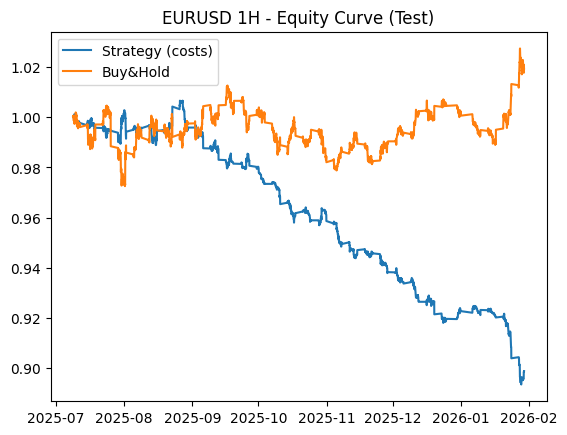

In [15]:
plt.figure()
plt.plot(bt.index, bt["equity"], label="Strategy (costs)")
plt.plot(bt.index, bt["buy_hold"], label="Buy&Hold")
plt.legend()
plt.title("EURUSD 1H - Equity Curve (Test)")
plt.show()
